### Introduction
In the second part of the multi-part mini project series, we explore sentiment analysis on the dataset acquired from bookshare.org free ('Once and Future King'). 
We'll apply sentiment analysis in two approaches:
* by sentence, and using Savitsky-Golay filter to trim the noise from signals through polynomial smoothing.
* by chapter, averaging the score from sentences per chapter and plotting them.

In [44]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.signal import savgol_filter

In [3]:
# settings
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(10,6), titlesize=16, titleweight='bold')
plt.rc('axes', titlesize=16, titleweight='bold', titlepad=10, 
       labelsize=14, labelweight='bold')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

In [4]:
# read dataframe from Part 1
df = pd.read_csv('cleaned_df.csv', index_col=0)
df

,title,content
0,The_Once_Future_King00001,"CHAPTER I On Mondays, Wednesdays and Fridays i..."
1,The_Once_Future_King00002,CHAPTER XII The battle of Bedegraine was foug...
2,The_Once_Future_King00003,CHAPTER XI Guenever sat in the Queen's chambe...


### Approach 1 - Sentiment by sentences

In [5]:
### Sentiment analysis by sentences
# extract the text per book
BOOKS = {}
for i in range(1,len(df)+1):
    BOOKS[i] = df['content'][i-1]

In [22]:
# function to split text by sentence
def split_txt_df(book):
    split_text = sent_tokenize(book)
    # create list of compound scores
    compound_scores = []
    analyzer = SentimentIntensityAnalyzer()
    for sentence in split_text:
        vs = analyzer.polarity_scores(sentence)
        compound_scores.append(vs['compound'])
    # consolidate into dataframe of sentence and compound score
    d = {'sentence': split_text, 'compound': compound_scores}
    sent_df = pd.DataFrame(d)
    return sent_df

# function to plot compound score
def sent_plot(series, title, ):
    filtered = savgol_filter(series, 151, 5)
    plt.plot(series, color='b', label='original')
    plt.plot(filtered, color='orange', label='filtered')
    plt.title(title)
    plt.xlabel('sentence index')
    plt.ylabel('compound score')
    plt.legend(bbox_to_anchor=(1.15,1), frameon=True, )
    plt.show()

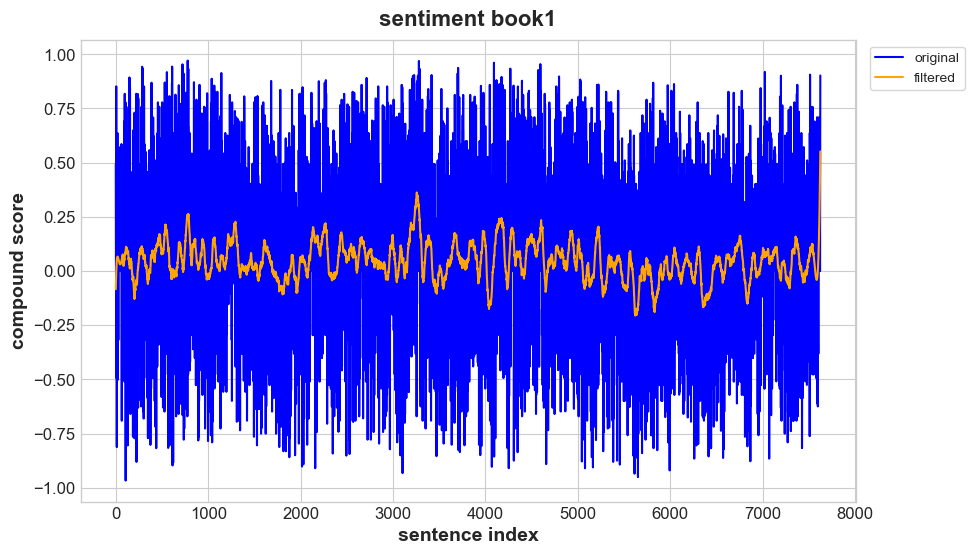

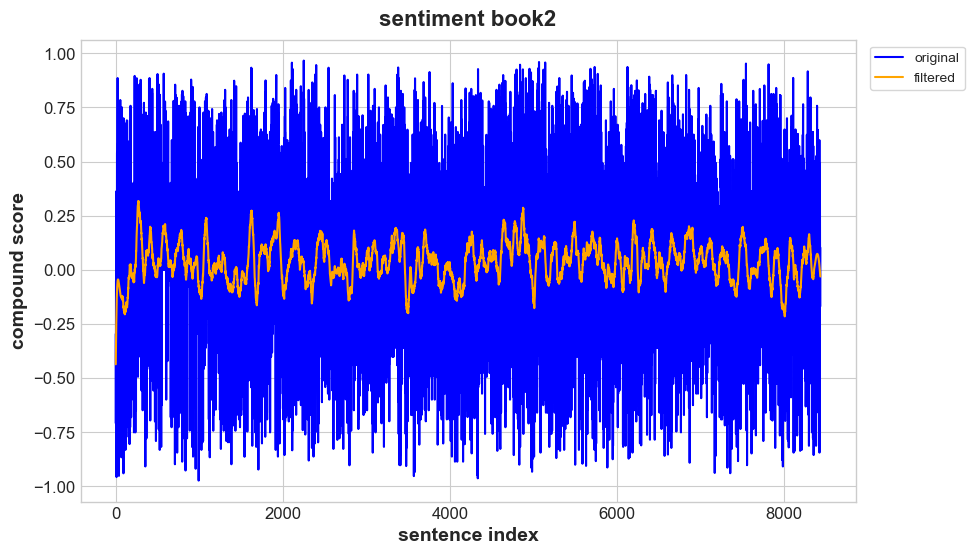

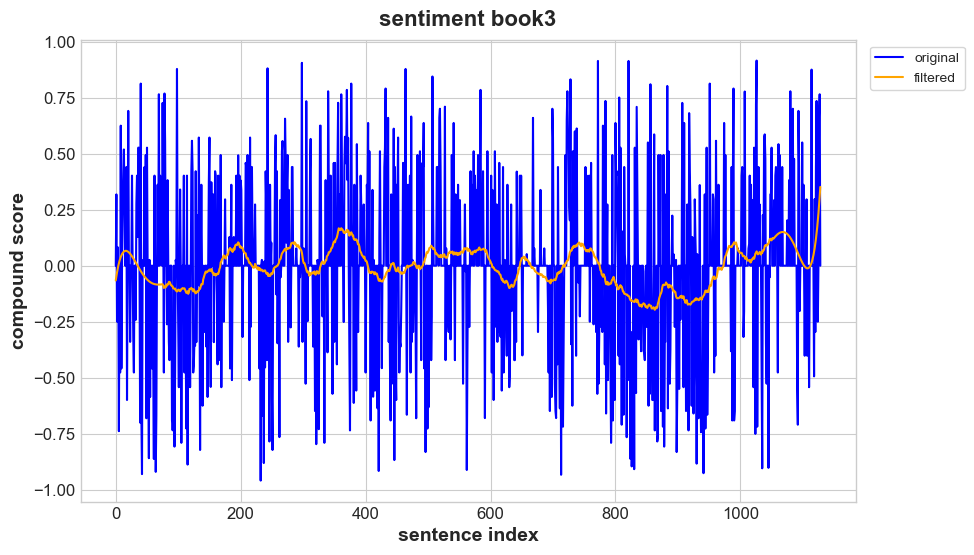

In [24]:
for i in range(1, len(df)+1):
    books_df = split_txt_df(BOOKS[i])
    sent_plot(books_df['compound'], f'sentiment book{i}', )

### Approach 2 - Sentiment by Chapters
we can measure the sentiment per chapter per book, and visualise it. Sentiment analyzer returns a dictionary of positive, negative and compound score values. For our purpose, the compound score suffices.

In [26]:
# function to measure and return sentiment by chapter per book as dataframe
def chapter_sentiment_frame(value, txt):
    # split text into chapters by input
    chapters = txt.split(value)[1:]
    # get list of sentences
    sent_list = [sent_tokenize(sent) for sent in chapters]
    # measure sentiment for each sentence
    overall_compound_scores = []
    analyzer = SentimentIntensityAnalyzer()
    for sentences in sent_list:
        compound_scores = []
        for sentence in sentences:
            vs = analyzer.polarity_scores(sentence)
            compound_scores.append(vs['compound'])
        overall_compound_scores.append(compound_scores)
    # get average compound scores of each chapter
    average_compound_scores = [np.average(ele) for ele in overall_compound_scores]
    # consolidate result into dataframe
    chapter = np.arange(1, len(average_compound_scores)+1)
    d = {'chapter':chapter, 'compound':average_compound_scores}
    df_ = pd.DataFrame(d)
    # normalize chapter number
    df_['chapter'] = df_['chapter']/ len(average_compound_scores)
    return df_

In [27]:
### Apply for all the three books, consolidate as a dictionary
FRAMES = {}
for i in range(1,len(df)+1):
    FRAMES[i] = chapter_sentiment_frame('CHAPTER', df['content'][i-1])

In [31]:
FRAMES[3]

,chapter,compound
0,0.25,0.005722
1,0.50,0.026867
2,0.75,-0.007533
3,1.00,-0.032825


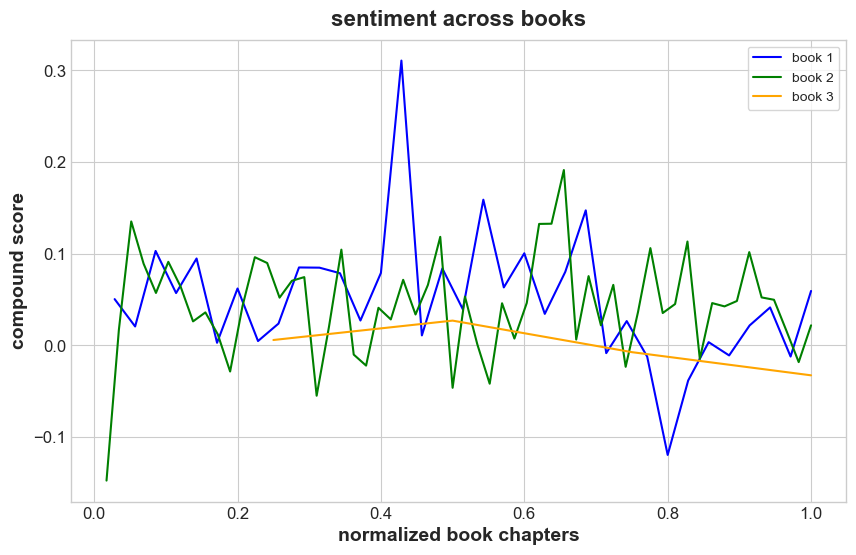

In [50]:
book_color = ['blue', 'green', 'orange']
for i in range(1,len(df)+1):
    plt.plot(FRAMES[i]['chapter'], FRAMES[i]['compound'], 
            color=book_color[i-1], label=f'book {i}')
plt.legend(frameon=True)
plt.title('sentiment across books')
plt.ylabel('compound score')
plt.xlabel('normalized book chapters')
plt.show()

The sentiments vary widely between book 1 and 2. There are both a peak and dip in sentiment for book 1. Book 2 started off with a negative sentiment. Book 3 started off with a generally neutral sentiment before tapering towards a slight negative.

That's it for now. In the last part, we'll export network graphing of the story characters.